In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.integrate import quad
from astropy import constants as const
from scipy.interpolate import interp1d

In [12]:
# (a) Calculate the age of the Universe (”cosmic time”) for each of these redshifts

from astropy.table import Table, Column
from astropy import units as u

data1 = {
    'z': [0.1, 0.35, 0.6, 0.85, 1.25, 1.75, 2.25, 3.25, 4.5, 5.9, 7.4],
    'log_psi': [-1.80, -1.49, -1.34, -1.08, -0.96, -0.87, -0.83, -1.09, -1.42, -1.65, -1.96]
}

data1['log_psi'] = data1['log_psi'] * (u.M_sun / u.yr / u.Mpc**3)

table1 = Table(data1)

data2 = {
    'z': [0.1, 0.35, 0.6, 0.8, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 5.0, 7.5],
    'log_rho': [8.60, 8.58, 8.50, 8.52, 8.30, 8.09, 7.90, 7.67, 7.58, 7.23, 6.79, 6.12]
}

data2['log_rho'] = data2['log_rho'] * (u.M_sun / u.Mpc**3)

table2 = Table(data2)


In [13]:
print("Table 1: z and log_psi")
print(table1)

Table 1: z and log_psi
 z         log_psi      
     solMass / (Mpc3 yr)
---- -------------------
 0.1                -1.8
0.35               -1.49
 0.6               -1.34
0.85               -1.08
1.25               -0.96
1.75               -0.87
2.25               -0.83
3.25               -1.09
 4.5               -1.42
 5.9               -1.65
 7.4               -1.96


In [14]:
print("Table 2: z and log_rho")
print(table2)

Table 2: z and log_rho
 z      log_rho    
     solMass / Mpc3
---- --------------
 0.1            8.6
0.35           8.58
 0.6            8.5
 0.8           8.52
1.25            8.3
1.75           8.09
2.25            7.9
2.75           7.67
3.25           7.58
3.75           7.23
 5.0           6.79
 7.5           6.12


In [15]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmic_time = [cosmo.age(z).to(u.Gyr) for z in table1['z']]

#add this cosmic time to the table

table1['cosmic_time'] = cosmic_time
print(table1)

 z         log_psi          cosmic_time    
     solMass / (Mpc3 yr)        Gyr        
---- ------------------- ------------------
 0.1                -1.8 12.165686389517036
0.35               -1.49  9.602745844922444
 0.6               -1.34  7.757289583942854
0.85               -1.08  6.398478063082306
1.25               -0.96  4.879756975473814
1.75               -0.87  3.661772834563974
2.25               -0.83 2.8699206566349504
3.25               -1.09  1.930799913977016
 4.5               -1.42 1.3150512164597155
 5.9               -1.65  0.936936658844834
 7.4               -1.96 0.6978999719386239


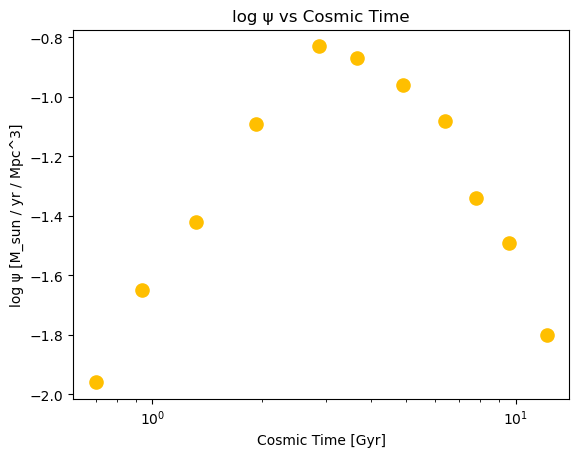

In [16]:
# (b) Plot the log ψ datapoints against cosmic time.

plt.scatter(table1['cosmic_time'], table1['log_psi'], color='#FFBF00', s=90)
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('log ψ [M_sun / yr / Mpc^3]')
plt.xscale('log')
plt.title('log ψ vs Cosmic Time')
plt.show()



Fitted parameters: A1 = 51.752, z1 = 0.558, A2 = 1.667, z2 = 1.685
R-squared: 0.9810087026527088


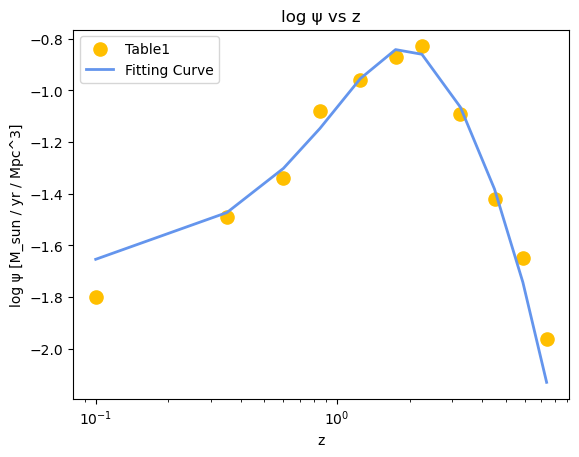

In [18]:
#(c) Match a fitting formula to the data. 

def psi_function(z, A1, z1, A2, z2):
    return 1 / (A1 * np.exp(-z / z1) + A2 * np.exp(z / z2))

table1['psi'] = 10**table1['log_psi']
popt, pcov = curve_fit(psi_function, table1['z'], table1['psi'],p0=[1, -1, 1, -1])

A1, z1, A2, z2 = popt

psi_fit = psi_function(table1['z'], *popt)

slope, intercept, r_value, p_value, std_err = linregress(table1['psi'], psi_fit)
r_squared = r_value**2

print(f"Fitted parameters: A1 = {A1:.3f}, z1 = {z1:.3f}, A2 = {A2:.3f}, z2 = {z2:.3f}") 
print(f"R-squared: {r_squared}")

plt.scatter(table1['z'], table1['log_psi'], color='#FFBF00', s=90,label='Table1')
plt.plot(table1['z'], np.log10(psi_function(table1['z'], *popt)), color='#6495ED',linewidth=2,label='Fitting Curve')
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('log ψ [M_sun / yr / Mpc^3]')
plt.title('log ψ vs z')
plt.legend()
plt.show()




$$\rho_{*}(z) = (1 - R) \int_{z}^{\infty} \frac{\psi(z')}{H(z')(1 + z')} \, dz'$$

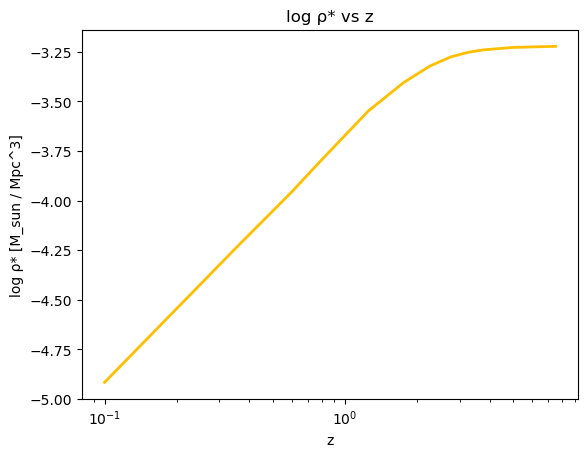

In [52]:
#(d) Integrate this fitted relation to predict the evolving stellar mass density.
#$$\rho_{*}(z) = (1 - R) \int_{z}^{\infty} \frac{\psi(z')}{H(z')(1 + z')} \, dz'$$

H0 = 70 * u.km / u.s / u.Mpc
Om0 = 0.3
R = 0.27  # return fraction

# Hubble parameter 
def H(z):
    return H0 * np.sqrt(Om0 * (1 + z)**3 + (1 - Om0))

def integrand(z, psi_func):
    return (psi_func(z) / (H(z) * (1 + z))).value

psi_interp = interp1d(table1['z'], table1['psi'], fill_value="extrapolate")
rho_star = []
for z in table2['z']:
    rho_star.append((1-R)*quad(integrand, 0, z, args=(psi_interp))[0])

table2['rho_star'] = rho_star

plt.plot(table2['z'], np.log10(table2['rho_star']), color='#FFBF00',linewidth=2)
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('log ρ* [M_sun / Mpc^3]')
plt.title('log ρ* vs z')
plt.show()
